<a id="section-one"></a>
# Overview of data

In this competition our goal is to predict the presence or absence of cancer in mammography images.

## How the data is organized

The images are organized in directories by patient id.

In [1]:
ls ../input/rsna-breast-cancer-detection/train_images | head -1 -n 4

10006/
10011/
10025/
10038/
ls: write error


Each directory contains several images.

In [2]:
ls ../input/rsna-breast-cancer-detection/train_images/57175

1084689895.dcm  110562898.dcm  1564996746.dcm  269811751.dcm


In [3]:
import pandas as pd
from matplotlib import pyplot as plt

sample_sub = pd.read_csv('../input/rsna-breast-cancer-detection/sample_submission.csv')

For each patient, we are to predict the presence or absence of cancer in the left and right breast.

Here is the submission format.

In [4]:
sample_sub

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


There are 11913 patients in the train set.

In [5]:
!ls -l ../input/rsna-breast-cancer-detection/train_images | wc -l # wc -l outputs one a count of one row too many when used like this! hence we need to subtract one to get the true count

11914


In test, we have access to just a single example!

In [6]:
ls ../input/rsna-breast-cancer-detection/test_images/10008

1591370361.dcm  361203119.dcm  68070693.dcm  736471439.dcm



However, once we submit from our notebook, the full test set will get mounted.

The images we will work with are in the DICOM format. Let us take a closer look at it.

## DICOM image format overview

A DICOM file consists of a header and image data sets packed into a single file. The information within the header is organized as a constant and standardized series of tags. By extracting data from these tags one can access important information regarding the patient demographics, study parameters, etc.

Let's look at a couple of images to gain a better intution on what types of images we are working here with.

In [7]:
import pydicom
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import glob

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


First, let's start with the metadata. Each image contains a rich metadata that might guide is in how we split the data for training (we might also want to provide some of this information directly to our model!)

In [8]:
example = '../input/rsna-breast-cancer-detection/train_images/10006/1459541791.dcm'
pydicom.dcmread(example)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183901.792591'
(0010, 0020) Patient ID                          LO: '10006'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10006
(0020, 000e) Series Instance

And now let us look at some images.

In [9]:
# source: https://www.kaggle.com/code/allunia/rsna-csf-cervical-spine-fracture-eda/notebook
def rescale_img_to_hu(dcm_ds):
    """Rescales the image to Hounsfield unit."""
    data = dcm_ds.pixel_array
    if dcm_ds.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    return data * dcm_ds.RescaleSlope + dcm_ds.RescaleIntercept

In [10]:
def show_images_for_patient(patient_id):
    patient_dir = os.path.join('../input/rsna-breast-cancer-detection/train_images', str(patient_id))
    num_images = len(glob.glob(f"{patient_dir}/*"))
    print(f"Number of images for patient: {num_images}")
    fig, axs = plt.subplots(2, 2, figsize=(24,15))
    axs = axs.flatten()
    for i, img_path in enumerate(list(Path(patient_dir).iterdir())):
        ds = pydicom.dcmread(img_path)
        axs[i].imshow(rescale_img_to_hu(ds), cmap="bone")

Number of images for patient: 4


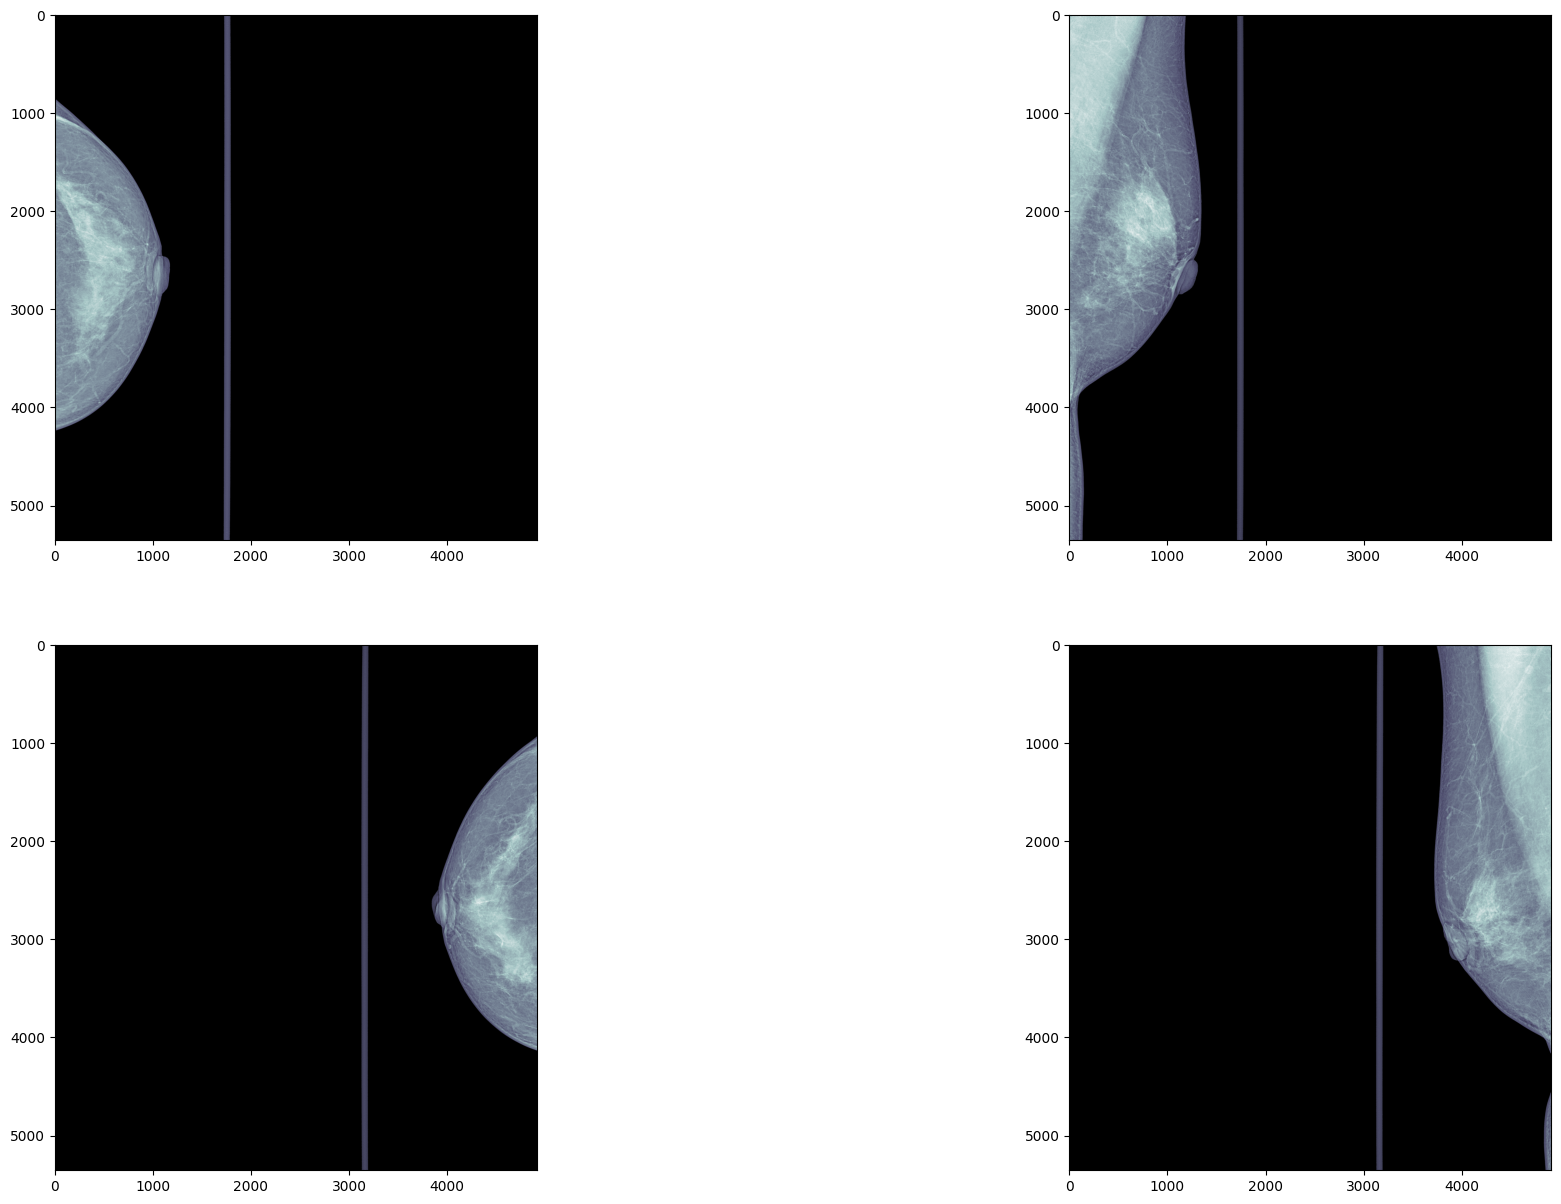

In [11]:
show_images_for_patient(10006)

As we see from the plots, the images are of considerable size.

We see that the breast occupies only a small portion of the image.

As such (especially given the limited compute budget!) it will most likely be a very good idea to find ways of cropping out the portions of the image htat do not contain any information! The divider line can serve an important role here.

## The competition metric

It is always a good idea to understand exactly the type of predictions our model will be required to deliver.

The metric that the organizers opted for here is the probabilistic F1 score:

$pF_1 = 2\frac{pPrecision \cdot pRecall}{pPrecision+pRecall}$

with:

$pPrecision = \frac{pTP}{pTP+pFP}$

$pRecall = \frac{pTP}{pTP+pFN}$

You can find a Python implementation of the metric [here](https://www.kaggle.com/code/sohier/probabilistic-f-score)

Our model should output the likelihood of cancer in the corresponding image.

So what are the labels we will train on?

In [12]:
train_csv = pd.read_csv('../input/rsna-breast-cancer-detection/train.csv')
train_csv.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


The targets are stored in the `train.csv` file along with some additional metadata.

They are stored in the `cancer` column. Additionally, the file provides mapping of images to `laterality` (whether an image is of the left or right breast -- this can be very useful in training).

And where can we find information on `laterality` (and other metadata) in test?

It is contained in the `test.csv` file.

In [13]:
test_csv = pd.read_csv('../input/rsna-breast-cancer-detection/test.csv')
test_csv

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


As expected, the test file doesn't contain the `cancer` column.

So how many images do we have to train on?

In [14]:
train_csv.shape[0], train_csv.patient_id.nunique()

(54706, 11913)

There are a total of 54706 images in train across 11913 patients.

## Distribution of labels

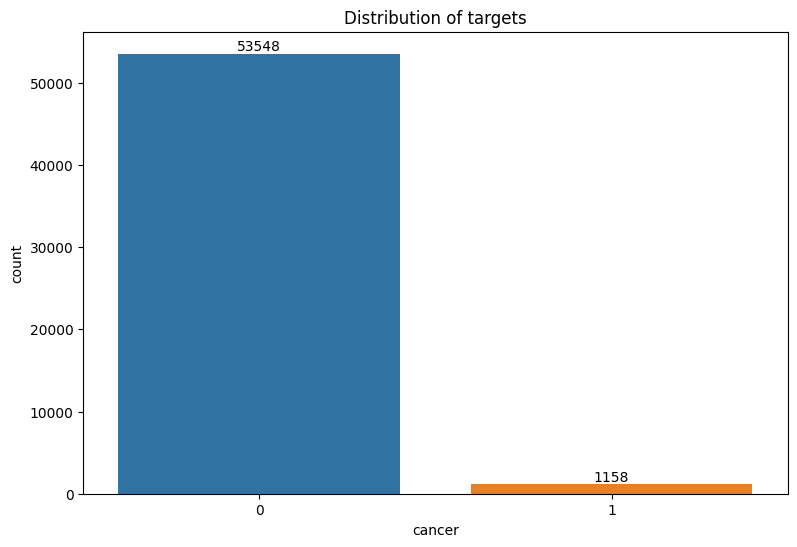

In [15]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=train_csv, x='cancer')
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Distribution of targets');

The classes are highly unbalanced! Most likely, we will need to address this in training (possibly via upsampling of the `cancer` class, downsampling of the `cancer absent`, class weights, etc).

<a id="section-two"></a>
# Training a fast.ai model

Let's now put all the pieces in place that we will need to trian a fast.ai model

To facilitate quick experimentation, I have processed [train images to PNGs](https://www.kaggle.com/competitions/rsna-breast-cancer-detection/discussion/369282) and shared them here: [RSNA Mammography -- images as PNGs (256px & 512px)](https://www.kaggle.com/datasets/radek1/rsna-mammography-images-as-pngs).

Here is everything that we need in order to get up and runnig quickly with the fast.ai library.

## Creating dataloaders

In [16]:
from fastai.data.all import *
from fastai.vision.all import *

path = '../input/rsna-mammography-images-as-pngs/images_as_pngs/train_images_processed'

train_csv = pd.read_csv('../input/rsna-breast-cancer-detection/train.csv')
fn2label = {fn: cancer_or_not for fn, cancer_or_not in zip(train_csv['image_id'].astype('str'), train_csv['cancer'])}

def label_func(path):
    return fn2label[path.stem]

dblock = DataBlock(
    blocks    = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = label_func,
    splitter  = RandomSplitter()
)
dsets = dblock.datasets(path)
dls = dblock.dataloaders(path)

And this is what a batch of our data will look like!

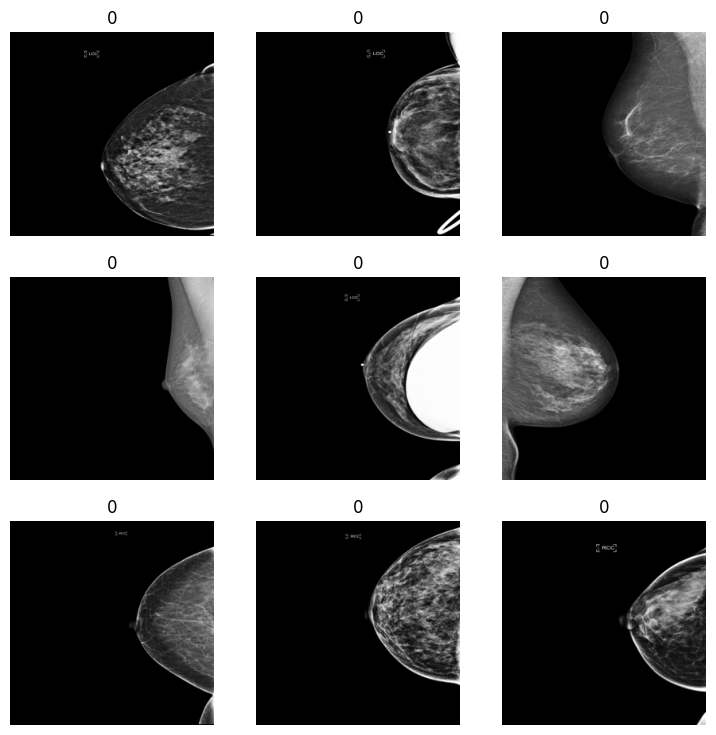

In [17]:
dls.show_batch()

## Creating the learner and training for a single epoch

In [18]:
learn = vision_learner(dls, resnet18, metrics=error_rate, pretrained=False)
learn.fit_one_cycle(1, 1e-2)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.111113,0.107455,0.022484,04:56


There is a lot of functionality in the fast.ai toolkit that can be particularly useful in this competition:

* training with one cycle (to make the best use of resources on Kaggle and to train better models)
* the [medical imaging module](https://docs.fast.ai/medical.imaging.html) that we can use for reading DICOM files directly
* image augmentation on the GPU (augmenting images is a compute-intensive process, on Kaggle we only have 2 CPU cores on GPU VMs so offloading augmenting our data to the super computer that a GPU is might lead to faster training)

<a id="section-three"></a>
# First submission

Let's take a look at how to create a first submission to understand what format of predictions is expected (and how to output them).

In the notebook, we don't have access to the actual test set, that is until we submit! Once we finish editing our notebook and submit, the full test set will get mounted to our notebook.

It will follow the structure of the stub test set we have mounted currently, but will contain more than just the single directory.

Here is what is currently mounted as the test set:

In [19]:
ls ../input/rsna-breast-cancer-detection/test_images

10008/


Let's put all of the machinery in place we will need for outputting predictions (and test that we got it right by outputting a prediction consisting of random floats between 0 and 1).

If our submission gets scored, we will know we got this right.

In [20]:
submission = pd.DataFrame(data={'prediction_id': test_csv['prediction_id'], 'cancer': np.random.rand(test_csv.shape[0])}).drop_duplicates(subset='prediction_id')
submission.head()

,prediction_id,cancer
0,10008_L,0.978225
2,10008_R,0.192685


In [21]:
submission.to_csv('submission.csv', index=False)

### Greetings to the author

Radek Osmulski https://www.kaggle.com/radek1